# Controversial titles

This notebook explores the Reddit titles and attempts to see if there is a relationship b/w titles and controversiality.

First, it explores the data a little. 

Then it uses various techniques, including NLP, to try to determine what in a title is so controversial.

In [1]:
import numpy as np
import pandas as pd
import gensim
import sklearn
import seaborn as sns
import spacy
import scipy
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import flair
import urllib
import math
import string
from time import time

from collections import Counter

%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('top_and_controversial_lg.csv')

# Warmup

In [3]:
lengths = pd.Series([len(x) for x in df.title])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6534 entries, 0 to 6533
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6534 non-null   int64  
 1   title          6534 non-null   object 
 2   score          6534 non-null   int64  
 3   upvote_ratio   6534 non-null   float64
 4   id             6534 non-null   object 
 5   url            6534 non-null   object 
 6   comms_num      6534 non-null   int64  
 7   created        6534 non-null   float64
 8   body           4 non-null      object 
 9   timestamp      6534 non-null   object 
 10  controversial  6534 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(5)
memory usage: 517.0+ KB


In [5]:
df.controversial.value_counts()

True     3603
False    2931
Name: controversial, dtype: int64

<AxesSubplot:xlabel='upvote_ratio', ylabel='count'>

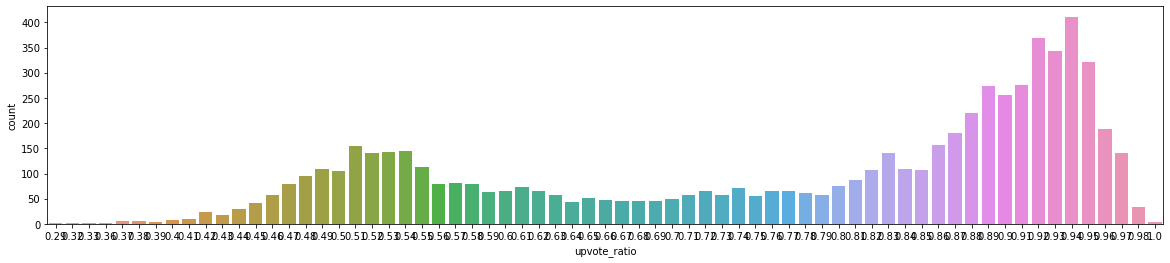

In [6]:
plt.figure(figsize=(20,4))
sns.countplot(x='upvote_ratio', data=df)

In [7]:
df_controversial = df[df.controversial.isin([True])]
df_top = df[~df.controversial.isin([True])]
df_controversial.head()

,Unnamed: 0,title,score,upvote_ratio,id,url,comms_num,created,body,timestamp,controversial
0,0,Elon Musk's promised ventilators never deliver...,53,0.50,g2edod,https://www.foxcarolina.com/elon-musks-promise...,396,1.587071e+09,NaN,2020-04-16 21:55:55,True
1,1,ISIS orders all women and girls in Mosul to un...,342,0.56,2bl8d7,http://www.theguardian.com/world/2014/jul/24/i...,1110,1.406234e+09,NaN,2014-07-24 21:36:44,True
2,2,Justin Bieber Arrested for Drag Racing / DUI (...,730,0.71,1vxp05,http://www.nbcmiami.com/news/Justin-Bieber-Arr...,3612,1.390507e+09,NaN,2014-01-23 19:48:28,True
3,3,Kanye West halts Sydney concert after two fans...,7435,0.62,2gd9kr,http://www.independent.co.uk/arts-entertainmen...,2700,1.410732e+09,NaN,2014-09-14 22:52:35,True
4,4,Actress Ellen Page has come out as a lesbian,1080,0.73,1xyegt,http://www.hrc.org/,2300,1.392464e+09,NaN,2014-02-15 11:26:10,True


<AxesSubplot:xlabel='upvote_ratio', ylabel='count'>

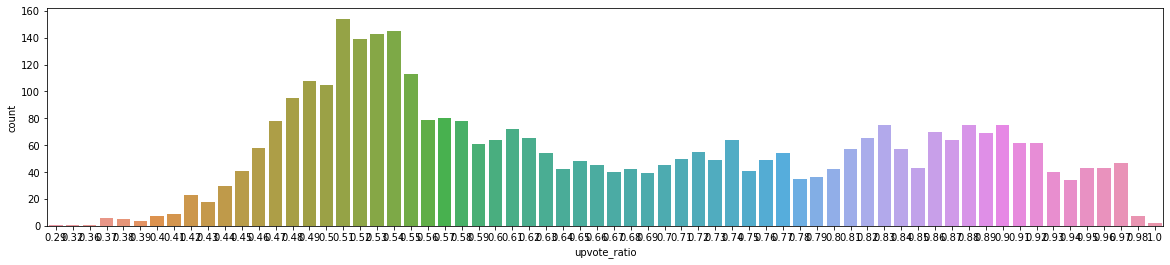

In [8]:
plt.figure(figsize=(20,4))
sns.countplot(x='upvote_ratio', data=df_controversial)

So clearly, the controversial ones tend to have lower upvote_ratios, but are still predominantly positive. It doesn't seem that upvote ratio alone determines whether something is controversial.
Let's take a look at upvote_ratio with regards to controversial status and number of comments.

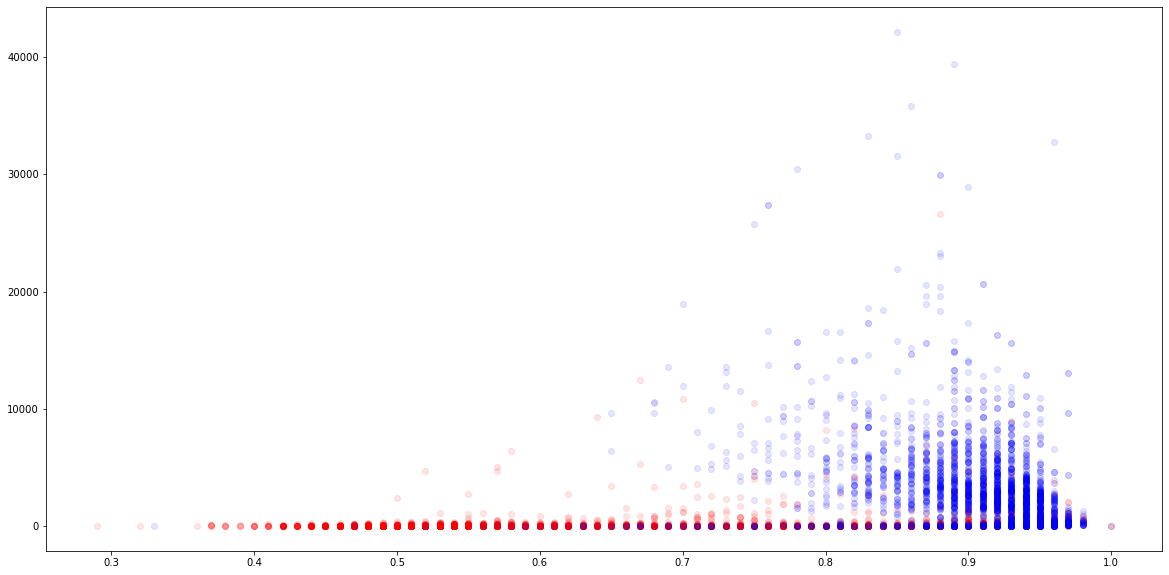

In [9]:
fig= plt.figure(figsize=(20,10))
plt.scatter(y='comms_num', x='upvote_ratio', alpha=0.1, data=df[df.controversial.isin([True])], c="red")  # controversial articles
plt.scatter(y='comms_num', x='upvote_ratio', alpha=0.1, data=df[~df.controversial.isin([True])], c="blue")  # not controversial


plt.show()

Interestingly enough, it would appear that controversial articles get fewer comments.
This could be because I'm comparing a dataset of controversial with the dataset of top, or just that the blue dots are covering up the red dots too well.

In [10]:
df.comms_num.max()

42164

In [11]:
df_controversial.comms_num.max()

26611

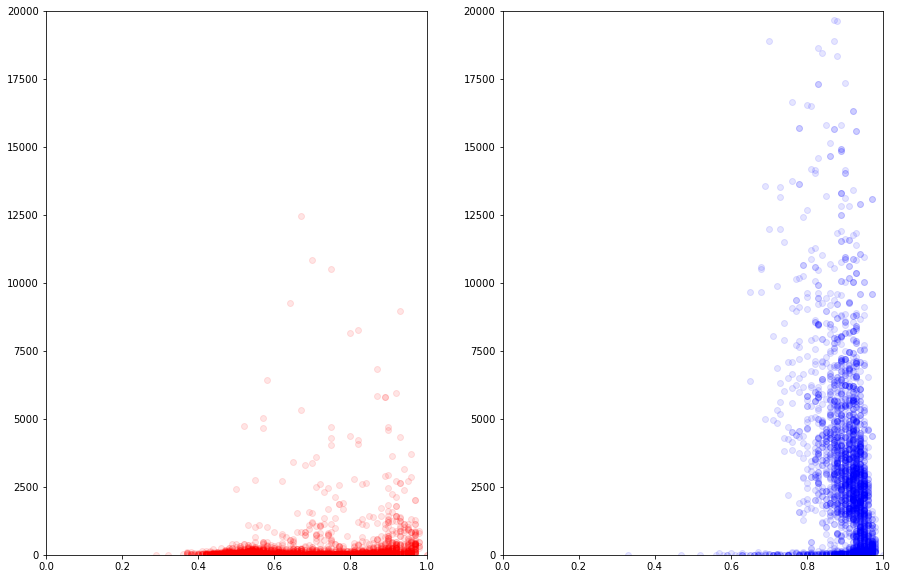

In [12]:
# Trying side by side to be sure
fig= plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.scatter(y='comms_num', x='upvote_ratio', alpha=0.1, data=df[df.controversial.isin([True])], c="red")  # controversial articles
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,20000])
plt.subplot(1,2,2)
plt.scatter(y='comms_num', x='upvote_ratio', alpha=0.1, data=df[~df.controversial.isin([True])], c="blue")  # not controversial

axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,20000])


plt.show()

Plotted this way, it's clear that top has a limit to the lower level while controversial seems only to have an upper limit. 
There's a good amount of overlap between 0.8 and ~0.95.

So it's clear that while both upvote_ratio and comments may be part of what determines hot or controversial, that's not the complete story.

What about score?

In [13]:
df.score.max()

226332

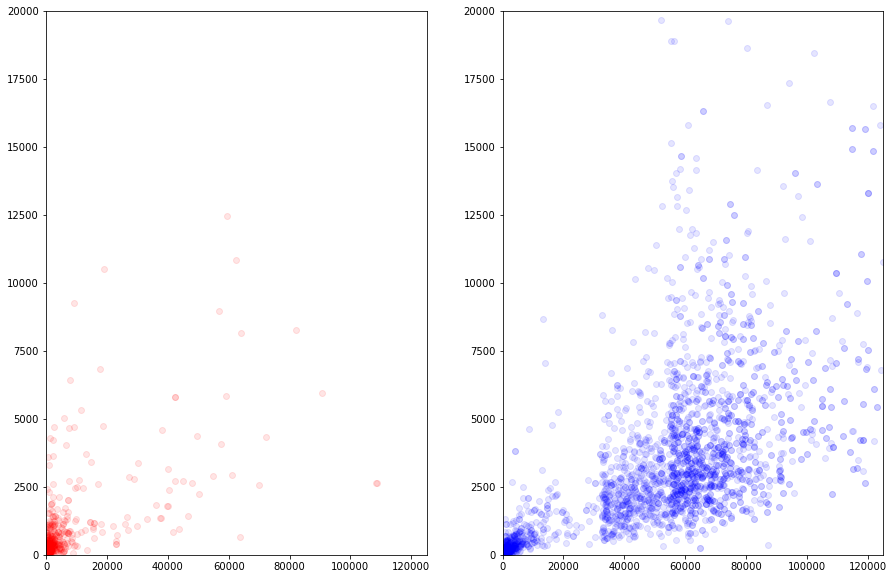

In [14]:
# Trying side by side to be sure
fig= plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.scatter(x='score', y='comms_num', alpha=0.1, data=df[df.controversial.isin([True])], c="red")  # controversial articles
axes = plt.gca()
axes.set_xlim([0,125000])
axes.set_ylim([0,20000])
plt.subplot(1,2,2)
plt.scatter(x='score', y='comms_num', alpha=0.1, data=df[~df.controversial.isin([True])], c="blue")  # not controversial

axes = plt.gca()
axes.set_xlim([0,125000])
axes.set_ylim([0,20000])


plt.show()

There's an interesting thing going on here, but there's a big gapof about 10k on the Top datasets.

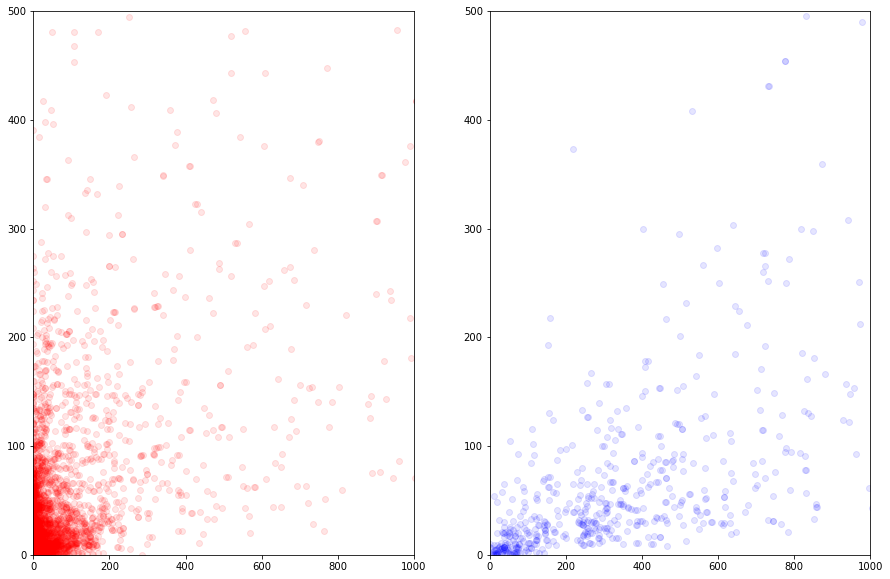

In [15]:
# Trying side by side to be sure
fig= plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.scatter(x='score', y='comms_num', alpha=0.1, data=df[df.controversial.isin([True])], c="red")  # controversial articles
axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([0,500])
plt.subplot(1,2,2)
plt.scatter(x='score', y='comms_num', alpha=0.1, data=df[~df.controversial.isin([True])], c="blue")  # not controversial

axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([0,500])


plt.show()

The gap persists in Top, but there's probably enough to work with here.

# Is there a relationship between titles and controversiality on Reddit?

This section uses various NLP methods to try to determine what causes an article in /news/ to be considered controversial.

### Title Length

Is there a direct relationship between the title length in characters or words and the controversiality? Perhaps users really are conflicted about concise titles, and want them to be longer...

In [16]:
# first, count characters in every title
# df['c'] = df.apply(lambda x: max(len(x['a']), len(x['b'])), axis=1)

df['char_count'] = df.apply(lambda row: len(row["title"]), axis=1)
df.head()

,Unnamed: 0,title,score,upvote_ratio,id,url,comms_num,created,body,timestamp,controversial,char_count
0,0,Elon Musk's promised ventilators never deliver...,53,0.50,g2edod,https://www.foxcarolina.com/elon-musks-promise...,396,1.587071e+09,NaN,2020-04-16 21:55:55,True,96
1,1,ISIS orders all women and girls in Mosul to un...,342,0.56,2bl8d7,http://www.theguardian.com/world/2014/jul/24/i...,1110,1.406234e+09,NaN,2014-07-24 21:36:44,True,77
2,2,Justin Bieber Arrested for Drag Racing / DUI (...,730,0.71,1vxp05,http://www.nbcmiami.com/news/Justin-Bieber-Arr...,3612,1.390507e+09,NaN,2014-01-23 19:48:28,True,52
3,3,Kanye West halts Sydney concert after two fans...,7435,0.62,2gd9kr,http://www.independent.co.uk/arts-entertainmen...,2700,1.410732e+09,NaN,2014-09-14 22:52:35,True,132
4,4,Actress Ellen Page has come out as a lesbian,1080,0.73,1xyegt,http://www.hrc.org/,2300,1.392464e+09,NaN,2014-02-15 11:26:10,True,44


In [17]:
# Add column for word_count
df['word_count'] = df.apply(lambda row: len(row["title"].split(" ")), axis=1)
df.head()

,Unnamed: 0,title,score,upvote_ratio,id,url,comms_num,created,body,timestamp,controversial,char_count,word_count
0,0,Elon Musk's promised ventilators never deliver...,53,0.50,g2edod,https://www.foxcarolina.com/elon-musks-promise...,396,1.587071e+09,NaN,2020-04-16 21:55:55,True,96,12
1,1,ISIS orders all women and girls in Mosul to un...,342,0.56,2bl8d7,http://www.theguardian.com/world/2014/jul/24/i...,1110,1.406234e+09,NaN,2014-07-24 21:36:44,True,77,13
2,2,Justin Bieber Arrested for Drag Racing / DUI (...,730,0.71,1vxp05,http://www.nbcmiami.com/news/Justin-Bieber-Arr...,3612,1.390507e+09,NaN,2014-01-23 19:48:28,True,52,9
3,3,Kanye West halts Sydney concert after two fans...,7435,0.62,2gd9kr,http://www.independent.co.uk/arts-entertainmen...,2700,1.410732e+09,NaN,2014-09-14 22:52:35,True,132,25
4,4,Actress Ellen Page has come out as a lesbian,1080,0.73,1xyegt,http://www.hrc.org/,2300,1.392464e+09,NaN,2014-02-15 11:26:10,True,44,9


In [18]:
# finding char and words min/max
char_min_max = [min(df.char_count), max(df.char_count)]
word_min_max = [min(df.word_count), max(df.word_count)]
print(f"The character count min and max are: {char_min_max[0]} and {char_min_max[1]}")
print(f"The word count min and max are: {word_min_max[0]} and {word_min_max[1]}")

The character count min and max are: 15 and 297
The word count min and max are: 1 and 57


In [19]:
df['char_count'].describe()

count    6534.000000
mean       74.679522
std        25.376356
min        15.000000
25%        59.000000
50%        71.000000
75%        86.000000
max       297.000000
Name: char_count, dtype: float64

In [20]:
n_bins = 100

In [21]:
# https://pbpython.com/pandas-qcut-cut.html
df["char_count_quantile"] = pd.qcut(df['char_count'], q=n_bins, precision=0, duplicates="drop")

In [22]:
char_count_quantile_cnts = df['char_count_quantile'].value_counts()

In [23]:
df_controversial = df[df.controversial.isin([True])]
char_count_quantile_cont_cnts = df_controversial['char_count_quantile'].value_counts()

In [24]:
distribution = char_count_quantile_cont_cnts/char_count_quantile_cnts
distribution

(14.0, 34.0]      0.628571
(34.0, 38.0]      0.628571
(38.0, 42.0]      0.662791
(42.0, 44.0]      0.691176
(44.0, 45.0]      0.585366
                    ...   
(112.0, 116.0]    0.344262
(116.0, 123.0]    0.466667
(123.0, 135.0]    0.469697
(135.0, 169.0]    0.444444
(169.0, 297.0]    0.515152
Name: char_count_quantile, Length: 68, dtype: float64

<AxesSubplot:>

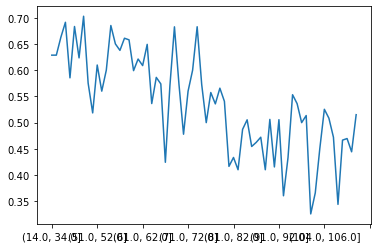

In [25]:
distribution.plot()

So shorter titles do seem to have some linear relationship with controversiality.

Let's repeat this with word count to be sure.

<AxesSubplot:>

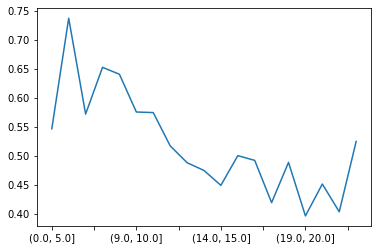

In [26]:
df["word_count_quantile"] = pd.qcut(df['word_count'], q=n_bins, precision=0, duplicates="drop")
word_count_quantile_cnts = df['word_count_quantile'].value_counts()
df_controversial = df[df.controversial.isin([True])]
word_count_quantile_cont_cnts = df_controversial['word_count_quantile'].value_counts()
distribution = word_count_quantile_cont_cnts/word_count_quantile_cnts
distribution.plot()

The same relationship is present here as well, and more obviously. There seems to be an uptick at the end, perhaps for those crazy long titles people don't want to read.

### Misspellings (to-do)

Skipping this for now. Need some kind of autocorrect suggestion magic and that's pretty heavy stuff.

### Link source

Are certain publications more likely to be controversial than others? Almost certainly!

In [27]:
# First, get the URL's root
test_row = df.loc[0]
test_row

Unnamed: 0                                                             0
title                  Elon Musk's promised ventilators never deliver...
score                                                                 53
upvote_ratio                                                         0.5
id                                                                g2edod
url                    https://www.foxcarolina.com/elon-musks-promise...
comms_num                                                            396
created                                                      1.58707e+09
body                                                                 NaN
timestamp                                            2020-04-16 21:55:55
controversial                                                       True
char_count                                                            96
word_count                                                            12
char_count_quantile                                

In [28]:
parsed_url = urllib.parse.urlparse(test_row.url)

In [29]:
root_url = parsed_url.netloc
root_url

'www.foxcarolina.com'

In [30]:
url_list = [urllib.parse.urlparse(row.url).netloc for index, row in df.iterrows()]
# def make_url_list():
#     for index, row in df.iterrows():
#         print(row.url)
#         break

# make_url_list()

In [31]:
# make it unique as a set: 
unique_url_list = set(url_list)
print(f"There are {len(unique_url_list)} unique sources out of {len(url_list)}")

There are 1166 unique sources out of 6534


So there are a lot of different sources. What are the value counts?

In [32]:
url_cts = Counter(url_list)
# url_cts

So most sources are infrequently posted, but there are quite a few with many submissions. Local news get frequent submissions as a collective group, but each individual one doesn't get many.

There are some international sites, some missing letters, and some shortened URLs.

We could try to combine and prune. Local news would be all be combined into one publisher, although that should probably not be the case as local news affiliates have common owners, such as Sinclair, which heavily influence or outright dictate what/how local affiliates report.

But for now let's just look at sources which have been used more than 5 times.

In [33]:
def make_usable_sources_df(cols):
    df_usable_sources = pd.DataFrame(columns=cols)
    
    for index, row in df.iterrows():
        url = urllib.parse.urlparse(row.url).netloc
        if url_cts[url] > 5:
            df_usable_sources = df_usable_sources.append(row, ignore_index=True)
        
    return df_usable_sources

cols = df.columns.values.tolist()
df_usable_sources = make_usable_sources_df(cols)

In [34]:
print(f"The original dataframe had {df.shape[0]} submittions and the usable sources dataframe has {df_usable_sources.shape[0]}")

The original dataframe had 6534 submittions and the usable sources dataframe has 4885


It's smaller by about a quarter, by discarding rarely used sources. Should probably add those back in at some point.

Actually, forget what we just did with the shrunken usable_sources df. Let's just proceed with the original DF, using the url as a stand in for publisher.

In [35]:
# string molly loves string stu

df['publisher'] = df.apply(lambda row: urllib.parse.urlparse(row.url).netloc, axis=1)

In [36]:
df = df.drop("body", axis=1)  # not sure where this column came from

A metric to analyze here would be % controversial by publisher. Raw count would be useless!

In [37]:
unique_publishers = df.publisher.unique()
unique_publishers[:5]

array(['www.foxcarolina.com', 'www.theguardian.com', 'www.nbcmiami.com',
       'www.independent.co.uk', 'www.hrc.org'], dtype=object)

In [38]:
def construct_publishers_df(df):
    columns=["publisher", "total", "controversial", "percent_controversial"]
    data = []
    
    for publisher in unique_publishers:
#         row = pd.DataFrame(columns=columns)
#         row.total = len(df.loc[df['publisher'] == publisher])
#         row.controversial = len(df.loc[(df['publisher'] == publisher) & df['controversial'] == True])
#         row.percent_controversial = round(row["controversial"]/row["total"] * 100, 2)
        row = [
            publisher,
            len(df.loc[df['publisher'] == publisher]),
            len(df.loc[(df['publisher'] == publisher) & df['controversial'] == True]),
        ]
        row.append(round(row[2]/row[1] * 100, 2))
        
        data.append(row)
    
    publishers_df = pd.DataFrame(data, columns=columns)
        
#     print(publishers_df)
    return publishers_df
        

In [39]:
publishers_df = construct_publishers_df(df)

In [40]:
publishers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   publisher              1166 non-null   object 
 1   total                  1166 non-null   int64  
 2   controversial          1166 non-null   int64  
 3   percent_controversial  1166 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 36.6+ KB


<Figure size 1800x720 with 0 Axes>

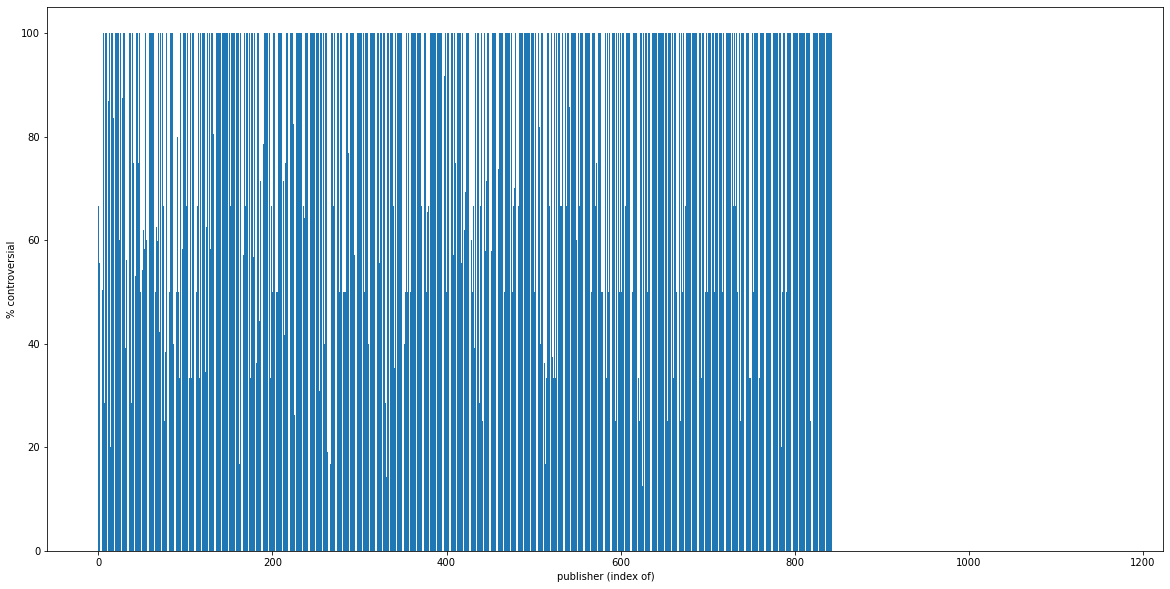

<Figure size 1800x720 with 0 Axes>

In [41]:
# fig, ax = plt.subplots()

# ax.plot(publishers_df.index, publishers_df.percent_controversial)
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(publishers_df.index, publishers_df.percent_controversial)
ax.set(xlabel='publisher (index of)', ylabel='% controversial')

plt.figure(figsize=(25,10))

In [42]:
# that's a bit tough, let's sort it first
publishers_df_sorted = publishers_df.sort_values(by="percent_controversial", ignore_index=True)
publishers_df_sorted.head()

,publisher,total,controversial,percent_controversial
0,www.fox26houston.com,1,0,0.0
1,www.ky3.com,1,0,0.0
2,wr.al,2,0,0.0
3,www.wdrb.com,1,0,0.0
4,www.abc-7.com,1,0,0.0


<Figure size 1800x720 with 0 Axes>

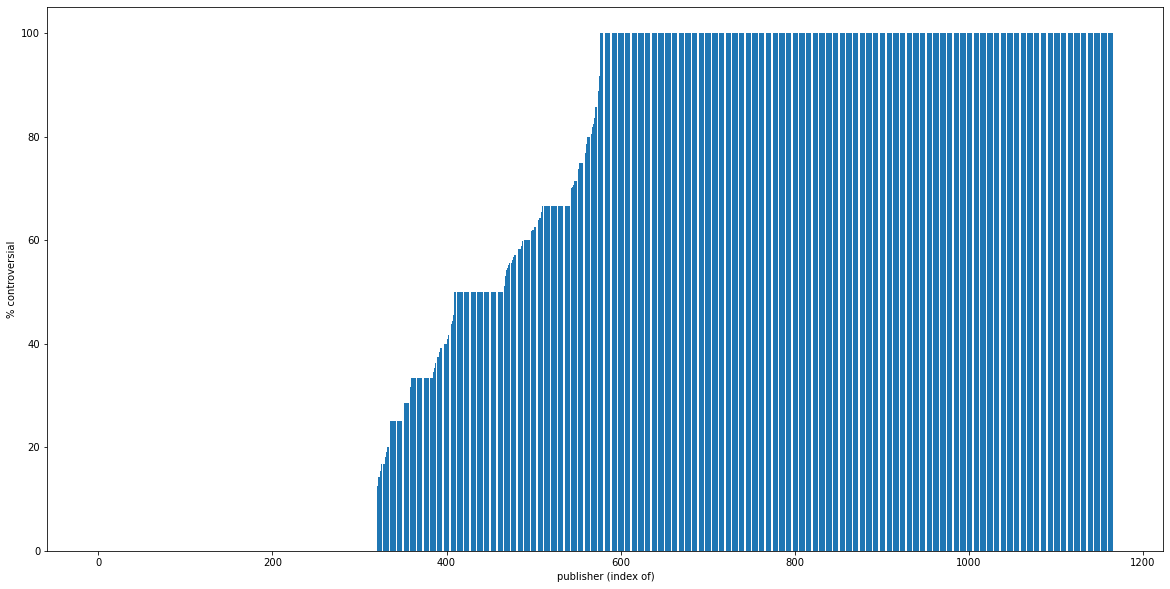

<Figure size 1800x720 with 0 Axes>

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(publishers_df_sorted.index, publishers_df_sorted.percent_controversial)
ax.set(xlabel='publisher (index of)', ylabel='% controversial')

plt.figure(figsize=(25,10))

So clearly some publishers are more controversial than others.

Revisiting the idea of excluding some low-frequency sources...

<Figure size 1800x720 with 0 Axes>

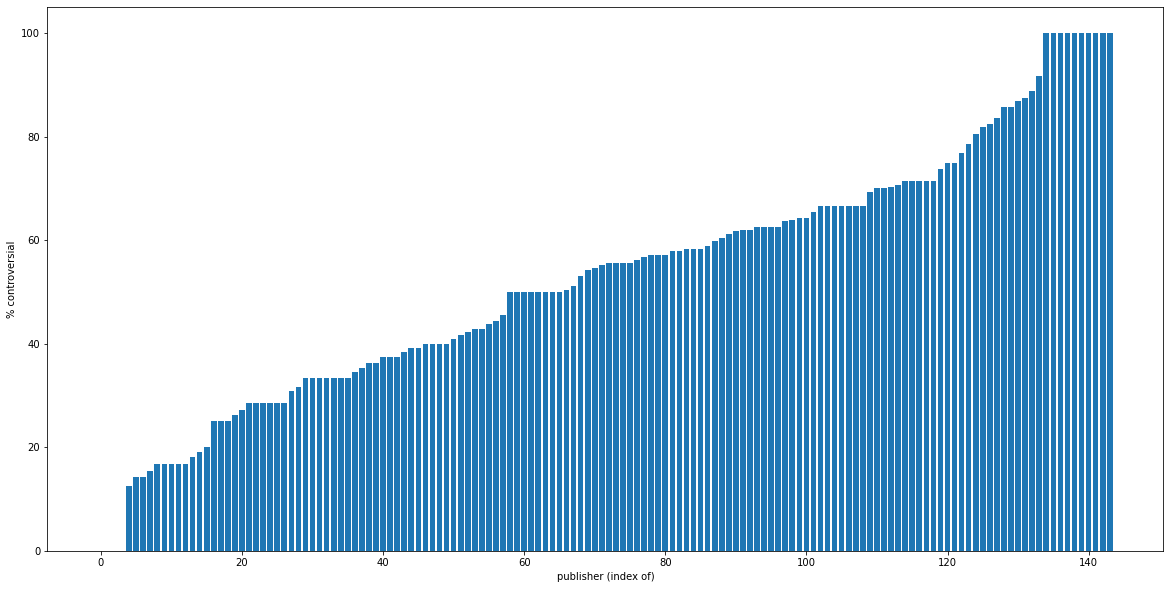

<Figure size 1800x720 with 0 Axes>

In [44]:
df_usable_sources['publisher'] = df_usable_sources.apply(lambda row: urllib.parse.urlparse(row.url).netloc, axis=1)
df_usable_sources = df_usable_sources.drop("body", axis=1)

unique_publishers = df_usable_sources.publisher.unique()
publishers_usable_df = construct_publishers_df(df_usable_sources)

publishers_usable_df_sorted = publishers_usable_df.sort_values(by="percent_controversial", ignore_index=True)
# publishers_usable_df_sorted.head()

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(publishers_usable_df_sorted.index, publishers_usable_df_sorted.percent_controversial)
ax.set(xlabel='publisher (index of)', ylabel='% controversial')

plt.figure(figsize=(25, 10))

Much nicer when we exclude uncommon sources, but the same effect is at play. Some publications are incredibly controversial, while others are not.

**To-do**: highlight big-time publishers with standout colors.

### ALL CAPS

Basically, if any title includes the characters in the lowercase alphabet, it is considered mixed_case, otherwise all_caps.

First, check if there are any articles that actually have all-caps titles.

In [45]:
# We'll brute force it
all_caps = []

for index, row in df.iterrows():
    for index, char in  enumerate(row.title):
        # found a lowercase char, can't be all caps
        if char in string.ascii_lowercase:
            break
        else:
            # at the end of the string
            if(index == len(row.title)-1):
                all_caps.append(row)
                print(f"All caps title found. \nThe title is: {row.title}.  \nIs it controversial? {row.controversial}")

All caps title found. 
The title is: STOP POSTING THE FUCKING MIAMI CANNIBAL/ZOMBIE ATTACK/FACE EATING HOBO/BATH SALTS STORY FOR CHRISTS SAKE!!!.  
Is it controversial? True
All caps title found. 
The title is: JUSSIE SMOLLETT ATTACK: BOTTLE WITH BLEACH ODOR FOUND NEAR ATTACK LOCATION; 'EMPIRE' ACTOR SUBMITS PHONE RECORDS.  
Is it controversial? True
All caps title found. 
The title is: VA: FAMILY FINDS, RETURNS NEARLY $1 MILLION IN CASH.  
Is it controversial? True


Only 3 titles are ALL CAPS. They are also all controversial.

Returning a million bucks in cash is definitely controversial in my book.

### Source article title doesn't match submission title

For this, we have to scrape the source articles for their titles.

In [46]:
df = pd.read_csv('top_and_controversial_lg_wpub.csv')

In [47]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,title,score,upvote_ratio,id,url,comms_num,created,timestamp,controversial,char_count,word_count,char_count_quantile,word_count_quantile,publisher,soup,p,titles_match
0,0,0,0,Elon Musk's promised ventilators never deliver...,53,0.50,g2edod,https://www.foxcarolina.com/elon-musks-promise...,396,1.587071e+09,2020-04-16 21:55:55,True,96,12,"(95.0, 96.0]","(11.0, 12.0]",www.foxcarolina.com,"\n<!DOCTYPE html>\n\n<html lang=""en"">\n<head>\...",[<p>This week Elon Musk unveiled his most sci-...,True
1,2,2,2,Justin Bieber Arrested for Drag Racing / DUI (...,730,0.71,1vxp05,http://www.nbcmiami.com/news/Justin-Bieber-Arr...,3612,1.390507e+09,2014-01-23 19:48:28,True,52,9,"(51.0, 52.0]","(8.0, 9.0]",www.nbcmiami.com,"<!DOCTYPE doctype html>\n\n<html class="""" lang...",[<p>Pop star Justin Bieber is facing driving u...,False
2,5,5,5,Call for Blood Donors After Orlando Massacre E...,83,0.53,4nrsyb,http://abcnews.go.com/Health/call-blood-donors...,257,1.465788e+09,2016-06-13 04:23:57,True,76,12,"(75.0, 76.0]","(11.0, 12.0]",abcnews.go.com,"\n<!DOCTYPE doctype html>\n\n<html lang=""en"">\...",[<p>— -- In the wake of the Orlando shooting t...,True
3,0,0,0,Elon Musk's promised ventilators never deliver...,53,0.50,g2edod,https://www.foxcarolina.com/elon-musks-promise...,396,1.587071e+09,2020-04-16 21:55:55,True,96,12,"(95.0, 96.0]","(11.0, 12.0]",www.foxcarolina.com,"\n<!DOCTYPE html>\n\n<html lang=""en"">\n<head>\...",[<p>This week Elon Musk unveiled his most sci-...,True
4,2,2,2,Justin Bieber Arrested for Drag Racing / DUI (...,730,0.71,1vxp05,http://www.nbcmiami.com/news/Justin-Bieber-Arr...,3612,1.390507e+09,2014-01-23 19:48:28,True,52,9,"(51.0, 52.0]","(8.0, 9.0]",www.nbcmiami.com,"<!DOCTYPE doctype html>\n\n<html class="""" lang...",[<p>Pop star Justin Bieber is facing driving u...,False


In [48]:
# see how many titles match vs don't match. 
# If either the <title> tag or the <h1> tag in an article contain the submission title, this counts as a True match

df_matched_titles = df.loc[df['titles_match'] == True]
df_unmatched_titles = df.loc[df['titles_match'] == False]
print(f"There are {df_matched_titles.shape[0]} titles which match, and {df_unmatched_titles.shape[0]} which do not")

There are 4164 titles which match, and 1707 which do not


Food for thought: is NaN counted as False?

Now let's see whether or not some relationship exists between a matching and non-matching title.

In [49]:
pct_match_cont = df.loc[(df['titles_match'] == True) & (df['controversial'] == True)].shape[0]/df_matched_titles.shape[0]

In [50]:
pct_unmatch_cont = df.loc[(df['titles_match'] == False) & (df['controversial'] == True)].shape[0]/df_unmatched_titles.shape[0]

In [51]:
print(f"When titles match, {pct_match_cont*100}% are controversial. When titles do NOT match, {pct_unmatch_cont*100}% are controversial.")

When titles match, 55.595581171950045% are controversial. When titles do NOT match, 51.66959578207382% are controversial.


There is little difference, and this is certainly within the margin of error. There is no initial indication that Redditors find submissions with a title that doesn't match to be any more controversial than those with titles that do match.

### Sentiment

We'll use the simple pre-trained sentiment model from Flair (https://github.com/flairNLP/flair) to see if there's a relationship between sentiment and controversiality.

Probably have to norm the distribution.

In [52]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2020-10-24 02:16:45,397 loading file /home/sheba/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [53]:
def predict_sentiment(text:str):
    s = flair.data.Sentence(text)
    flair_sentiment.predict(s)
    total_sentiment = s.labels
    return str(total_sentiment[0].value)

In [54]:
df["sentiment"] = df.apply(lambda row: predict_sentiment(row.title), axis=1)

In [55]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,title,score,upvote_ratio,id,url,comms_num,created,...,controversial,char_count,word_count,char_count_quantile,word_count_quantile,publisher,soup,p,titles_match,sentiment
0,0,0,0,Elon Musk's promised ventilators never deliver...,53,0.50,g2edod,https://www.foxcarolina.com/elon-musks-promise...,396,1.587071e+09,...,True,96,12,"(95.0, 96.0]","(11.0, 12.0]",www.foxcarolina.com,"\n<!DOCTYPE html>\n\n<html lang=""en"">\n<head>\...",[<p>This week Elon Musk unveiled his most sci-...,True,NEGATIVE
1,2,2,2,Justin Bieber Arrested for Drag Racing / DUI (...,730,0.71,1vxp05,http://www.nbcmiami.com/news/Justin-Bieber-Arr...,3612,1.390507e+09,...,True,52,9,"(51.0, 52.0]","(8.0, 9.0]",www.nbcmiami.com,"<!DOCTYPE doctype html>\n\n<html class="""" lang...",[<p>Pop star Justin Bieber is facing driving u...,False,NEGATIVE
2,5,5,5,Call for Blood Donors After Orlando Massacre E...,83,0.53,4nrsyb,http://abcnews.go.com/Health/call-blood-donors...,257,1.465788e+09,...,True,76,12,"(75.0, 76.0]","(11.0, 12.0]",abcnews.go.com,"\n<!DOCTYPE doctype html>\n\n<html lang=""en"">\...",[<p>— -- In the wake of the Orlando shooting t...,True,NEGATIVE
3,0,0,0,Elon Musk's promised ventilators never deliver...,53,0.50,g2edod,https://www.foxcarolina.com/elon-musks-promise...,396,1.587071e+09,...,True,96,12,"(95.0, 96.0]","(11.0, 12.0]",www.foxcarolina.com,"\n<!DOCTYPE html>\n\n<html lang=""en"">\n<head>\...",[<p>This week Elon Musk unveiled his most sci-...,True,NEGATIVE
4,2,2,2,Justin Bieber Arrested for Drag Racing / DUI (...,730,0.71,1vxp05,http://www.nbcmiami.com/news/Justin-Bieber-Arr...,3612,1.390507e+09,...,True,52,9,"(51.0, 52.0]","(8.0, 9.0]",www.nbcmiami.com,"<!DOCTYPE doctype html>\n\n<html class="""" lang...",[<p>Pop star Justin Bieber is facing driving u...,False,NEGATIVE


In [56]:
df_neg = df.loc[df["sentiment"] == "NEGATIVE"]
df_pos = df.loc[df["sentiment"] == "POSITIVE"]

In [57]:
df["sentiment"].value_counts()

NEGATIVE    4628
POSITIVE    1243
Name: sentiment, dtype: int64

In [58]:
print(f"There are {df_neg.shape[0]} negative titles and {df_pos.shape[0]} positive")

There are 4628 negative titles and 1243 positive


News titles are overwhelmingly negative in this dataset. Now which has more controversy?

In [59]:
pct_neg_cont = df.loc[(df["sentiment"] == "NEGATIVE") & (df['controversial'] == True)].shape[0]/df_neg.shape[0]
pct_pos_cont = df.loc[(df["sentiment"] == "POSITIVE") & (df['controversial'] == True)].shape[0]/df_pos.shape[0]
print(f"When titles have negative sentiment, {pct_neg_cont*100}% are controversial. When titles are positive, {pct_pos_cont*100}% are controversial.")

When titles have negative sentiment, 52.96024200518582% are controversial. When titles are positive, 60.016090104585686% are controversial.


Curiously, negative sentiment titles are less likely to be controversial than positive sentiment titles. This is still likely within a reasonable margin of error. Let's save the data to include this sentiment.

In [60]:
df.to_csv('top_and_controversial_lg_1.csv')

### Bag of Words

Let's do a naive BoW modeling to see if there's something between specific words chosen and controversiality.

In [61]:
df = pd.read_csv('top_and_controversial_lg_1.csv')

In [62]:
t0 = time()

nlp = spacy.load('en')
nlp.max_length = 30000000

common_words = []

# store spacy_doc obj for each author
cont_docs = {}

for controversy in [True, False]:
    corpus = ""
    content = df.loc[df.controversial==controversy, 'title']
    
    # merge 
    for title in content:
        corpus = corpus + title
    doc = nlp(corpus)
    
    # store doc in dict
    cont_docs[controversy] = doc
    
    #filter out punctuation and stop words
    lemmas = [token.lemma_ for token in doc 
             if not token.is_punct and not token.is_stop]
    
    # return most common words of that bias's corpus
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # add them to the list of words by all authors
    for word in bow:
        common_words.append(word)
    
# eliminate dups
common_words = set(common_words)

print('Total num of common words: ', len(common_words))
print("Done in %0.3fs" % (time() -t0))

Total num of common words:  1380
Done in 42.765s


In [63]:
lengths = []
for k, v in cont_docs.items():
    print(k, 'corpus contains', len(v), ' words.')
    lengths.append(len(v))

True corpus contains 37370  words.
False corpus contains 33571  words.


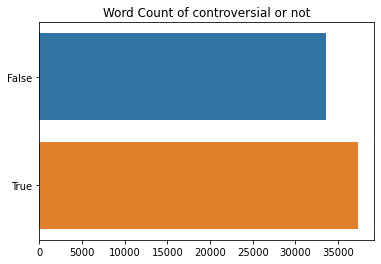

In [64]:
sns.barplot(x=lengths, y=[True, False], orient='h')
plt.title('Word Count of controversial or not')
plt.show()

In [65]:
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Count of all common_words: ', len(common_words))
print('Count of lowercase common_words: ', np.sum([word.islower() for word in common_words]))

# turn all common_words into lowercase
common_words  = [ word.lower() for word in common_words]
print('Count of lowercase common_words (After Conversion): ', np.sum([word.islower() for word in common_words]))

Count of all common_words:  1380
Count of lowercase common_words:  998
Count of lowercase common_words (After Conversion):  1332


In [66]:
if 'title' in common_words:
    common_words.remove('title')
    
if 'controversial' in common_words:
    common_words.remove('controversial')

In [67]:
common_words = set(common_words)
len(common_words)

1295

In [68]:
bow_counts = pd.DataFrame()

for c in [True, False]:
    # select all titles
    titles = df.loc[df.controversial==c,:]
    bow_counts = bow_counts.append(titles)

bow_counts = bow_counts.reset_index().drop(['index','Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', "Unnamed: 0.1.1.1"],1)

# use common_words as cols of temp DF
tdf = pd.DataFrame(columns=common_words)

# join BOW features w/ titls' content
bow_counts = bow_counts.join(tdf)

# initialize rows w/ 0s
bow_counts.loc[:, common_words] = 0

In [69]:
# fill df w/ cts of each feature in each title
t0 = time()

for i, title in enumerate(bow_counts.title):
    doc = nlp(title)
    
    for token in doc:
        if token.lemma_.lower() in common_words:
            try:
                bow_counts.loc[i, token.lemma_.lower()] += 1
            except Exception as e:
                print(e)
                print(token)
                print(bow_counts.loc[i, token.lemma_.lower()])
    # print msg every X articles
    if i% 50 == 0:
        if time() - t0 < 3600: # if less than an hours in seconds
            print("Article ", i, " done after ", (time()-t0)/60, ' minutes')
        else:
            print("Article ", i, " done after ", (time()-t0)/60/60, ' hours')

Article  0  done after  0.000948790709177653  minutes
Article  50  done after  0.018854467074076335  minutes
Article  100  done after  0.036472233136494954  minutes
Article  150  done after  0.05573849678039551  minutes
Article  200  done after  0.07278178135553996  minutes
Article  250  done after  0.09003118673960368  minutes
Article  300  done after  0.10877352555592855  minutes
Article  350  done after  0.12599432071050007  minutes
Article  400  done after  0.14340598185857137  minutes
Article  450  done after  0.16126582622528077  minutes
Article  500  done after  0.1796597957611084  minutes
Article  550  done after  0.1971360683441162  minutes
Article  600  done after  0.215854545434316  minutes
Article  650  done after  0.23266605933507284  minutes
Article  700  done after  0.2505001465479533  minutes
Article  750  done after  0.2675968647003174  minutes
Article  800  done after  0.2847477634747823  minutes
Article  850  done after  0.3022769927978516  minutes
Article  900  done

In [70]:
# bow_counts.to_pickle('title_bow_counts')

In [84]:
bow_counts = pd.read_pickle('title_bow_counts')

In [85]:
bow_counts.columns[:20]

Index(['title', 'score', 'upvote_ratio', 'id', 'url', 'comms_num', 'created',
       'timestamp', 'controversial', 'char_count', 'word_count',
       'char_count_quantile', 'word_count_quantile', 'publisher', 'soup', 'p',
       'titles_match', 'sentiment', 'statue', 'fraud'],
      dtype='object')

In [87]:
y = bow_counts['controversial']

# drop all columns except the word counts
X = bow_counts.drop(['title', 'score', 'upvote_ratio', 'id', 'url', 'comms_num', 'created',
       'timestamp', 'controversial', 'char_count', 'word_count',
       'char_count_quantile', 'word_count_quantile', 'publisher', 'soup','p','titles_match','sentiment'],1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2, 
                                                   random_state = 42,
                                                   stratify=y)
# X_train.to_csv('title_bow_counts_X_train.csv')
# X_test.to_csv('title_bow_counts_X_test.csv')
# y_train.to_csv('title_bow_counts_y_train.csv')
# y_test.to_csv('title_bow_counts_y_test.csv')

In [73]:
X.head() # sanity check

,statue,fraud,shooting,slave,fee,get,immigrant,throw,protection,email,...,monument,mom,honor,katrina,hundred,single,escape,eye,block,plane
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
metrics = ['Algorithm', 'n_train', 'Features', 'ARI', 'Homogeneity',
          'Silhouette', 'Mutual_Info', 'Vross_val', 'Train_accuracy',
          'Test_accuracy']
performance = pd.DataFrame(columns=metrics)

In [89]:
def evaluate_clust(clust, params, features, i):
    t0 = time()
    print('\n','-'*40, '\n', clust.__class__.__name__, '\n', '-'*40)
    
    # find best params based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clust, params, scoring=score, cv=3).fit(X,y)
    print("Best params: ", search.best_params_)
    y_pred = search.best_estimator_.fit_predict(X)
    print(y_pred)
    
    ari = adjusted_rand_score(y, y_pred)
    performance.loc[i, 'ARI'] = ari
    print(f"Adjusted Rand-Index: {ari:.3f}")
    
    hom = homogeneity_score(y, y_pred)
    performance.loc[i, 'Homogeneity'] = hom
    print(f'Homogeneity Score: {hom:.3f}')
    
    sil = silhouette_score(X, y_pred)
    performance.loc[i, 'Silhouette'] = sil
    print(f"Silhouette Score: {sil:.3f}")
    
    nmi = normalized_mutual_info_score(y, y_pred)
    performance.loc[i, 'Mutual_Info'] = nmi
    print(f"Normalized Mutual-Info Score: {nmi:.3f}")
    
    performance.loc[i, 'n_train'] = len(X)
    performance.loc[i, 'Features'] = features
    performance.loc[i, 'Algorithm'] = clust.__class__.__name__
    
    # print contingency matrix
    crosstab = pd.crosstab(y, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(time()-t0, ' seconds.')


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best params:  {'init': 'random', 'n_clusters': 25, 'n_init': 20, 'precompute_distances': False}
[ 3 22 19 ... 11 11 11]
Adjusted Rand-Index: 0.010
Homogeneity Score: 0.015
Silhouette Score: 0.023
Normalized Mutual-Info Score: 0.009


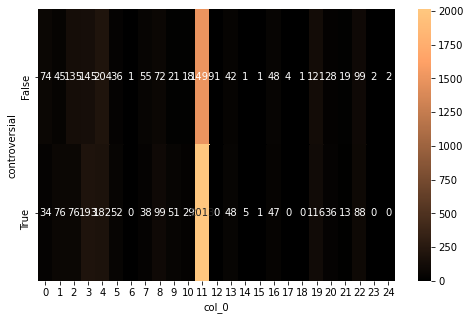

195.0809404850006  seconds.


In [90]:
clust = KMeans()
params = {
    'n_clusters': np.arange(10, 30, 5),
    'init': ['k-means++', 'random'],
    'n_init': [10,20],
    'precompute_distances': [True, False]
}
evaluate_clust(clust, params, features='BOW', i=0)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best params:  {}
[0 0 0 ... 0 0 0]
Adjusted Rand-Index: 0.003
Homogeneity Score: 0.023
Silhouette Score: 0.137
Normalized Mutual-Info Score: 0.035


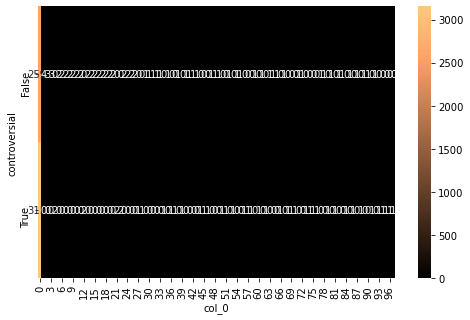

2256.230719804764  seconds.


In [91]:
clust = MeanShift()

params = {}
evaluate_clust(clust, params, features='BOW', i=1)

In [92]:
clust = AffinityPropagation()

params = {
    'damping': [0.5, 0.7, 0.9],
    'max_iter': [200, 500]
}

evaluate_clust(clust, params, features="BOW", i=2)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best params:  {'damping': 0.5, 'max_iter': 200}
[-1 -1 -1 ... -1 -1 -1]
Adjusted Rand-Index: 0.000
Homogeneity Score: 0.000


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Adjusted Rand-Index: 0.001
Homogeneity Score: 0.004
Normalized Mutual-Info Score: 0.007


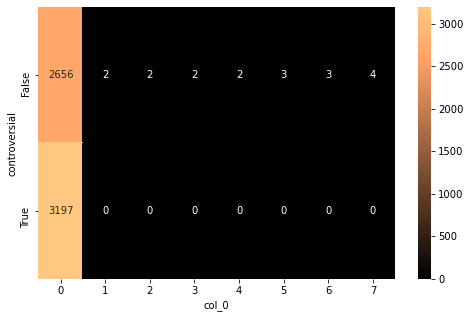

320.6299216747284  seconds.


In [93]:
# spectral clustering CBOW
# can't use .fit
clust = SpectralClustering()
params={
    'n_clusters': np.arange(10,26, 5),
    # 'eigen_solver': ['arpack', 'lobpcg', None],
    'n_init':[15, 25],
    'assign_labels': ['kmeans', 'discretize']
}

features = 'BOW'

i = 3
t0 = time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i, 'ARI'] = ari
print(f"Adjusted Rand-Index: {ari:.3f}")

hom = homogeneity_score(y, y_pred)
performance.loc[i, 'Homogeneity'] = hom
print(f'Homogeneity Score: {hom:.3f}')

# sil = silhouette_score(X, y_pred)
# performance.loc[i, 'Silhouette'] = sil
# print(f"Silhouette Score: {sil:.3f}")

nmi = normalized_mutual_info_score(y, y_pred)
performance.loc[i, 'Mutual_Info'] = nmi
print(f"Normalized Mutual-Info Score: {nmi:.3f}")

performance.loc[i, 'n_train'] = len(X)
performance.loc[i, 'Features'] = features
performance.loc[i, 'Algorithm'] = clust.__class__.__name__

# print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0, ' seconds.')

In [94]:
performance.iloc[:,:7]

,Algorithm,n_train,Features,ARI,Homogeneity,Silhouette,Mutual_Info
0,KMeans,5871,BOW,0.00985428,0.0153408,0.0225289,0.00877557
1,MeanShift,5871,BOW,0.0031543,0.0227973,0.136801,0.0352752
2,NaN,NaN,NaN,0,0,NaN,NaN
3,SpectralClustering,5871,BOW,0.00121881,0.00350684,NaN,0.00675253


In [95]:
def score_optimization(clf, params, features, i):
    t0 = time()
    #heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
    # find best params based on sorting of choices
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clf, params, scoring=score, cv=3).fit(X,y)
    
    #extract best estimator
    best = search.best_estimator_
    print("Best params: ", search.best_params_)
    
    # cross-validate on all the data
    cv = cross_val_score(X=X, y=y, estimator=best, cv=5)
    print("\nCross-val scores(All Data): ", cv)
    print("Mean cv score: ", cv.mean())
    performance.loc[i, 'Cross_Val'] = cv.mean()
    
    # get train accuracy
    best = best.fit(X_train, y_train)
    train = best.score(X=X_train, y=y_train)
    performance.loc[i, 'Train_Accuracy'] = train
    print("\nTrain Accuracy Score: ", train)
    
    # get test acc
    test = best.score(X=X_test, y=y_test)
    performance.loc[i, 'Test_Acc'] = test
    print("\nTest Acc Score: ", test)
    
    y_pred = best.predict(X_test)
    
    ari = adjusted_rand_score(y_test, y_pred)
    performance.loc[i, "ARI"] = ari
    print(f"\nAdjusted Rand-Index: {ari:.3f}")
    
    hom = homogeneity_score(y_test, y_pred)
    performance.loc[i, "Homogeneity"] = hom
    print(f"Homogeneity score: {hom:.3f}")
    
    sil = silhouette_score(X_test, y_pred)
    performance.loc[i, 'Silhouette'] = sil
    print(f"Silhouette score: {sil: .3f}")
    
    nmi = normalized_mutual_info_score(y_test, y_pred)
    performance.loc[i, 'Mutual_Info'] = nmi
    print(f"Normed mutual-info score: {nmi:.3f}")
    
    print(classification_report(y_test, y_pred))
    
    conf_matrix = pd.crosstab(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    performance.loc[i,'train'] = len(X_train)
    performance.loc[i, 'Features'] = features
    performance.loc[i, 'Algorithm'] = clf.__class__.__name__
    print(time() - t0, 'seconds')


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best params:  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-val scores(All Data):  [0.73787234 0.68057922 0.63543441 0.69591141 0.70272572]
Mean cv score:  0.6905046214070826

Train Accuracy Score:  0.825809199318569

Test Acc Score:  0.691063829787234

Adjusted Rand-Index: 0.145
Homogeneity score: 0.104
Silhouette score:  0.012
Normed mutual-info score: 0.104
              precision    recall  f1-score   support

       False       0.67      0.63      0.65       535
        True       0.71      0.74      0.72       640

    accuracy                           0.69      1175
   macro avg       0.69      0.69      0.69      1175
weighted avg       0.69      0.69      0.69      1175



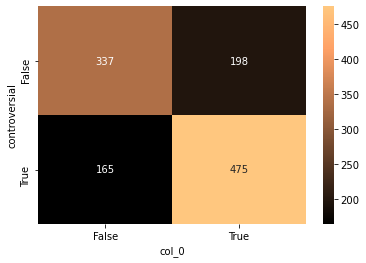

180.37155723571777 seconds


In [96]:
params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'C': [0.3, 0.5, 0.7, 1.0],
        'penalty':['l2']
    },
    {
        'solver': ['liblinear', 'saga'],
        'C': [0.3, 0.5, 0.7, 1.0],
        'penalty':['l1','l2']
    }
]

clf = LogisticRegression(n_jobs =-1)  # use all CPU

score_optimization(clf=clf, params=params, features="BOW", i=4)

Long story short, unsupervised bag of words doesn't seem to be any good at determining any relationship between words in the title and controversiality. There is some success in supervised logistic regression.


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best params:  {'criterion': 'entropy'}

Cross-val scores(All Data):  [0.74468085 0.74787053 0.66183986 0.7879046  0.6967632 ]
Mean cv score:  0.7278118090543333

Train Accuracy Score:  0.9970187393526405

Test Acc Score:  0.7293617021276596

Adjusted Rand-Index: 0.210
Homogeneity score: 0.158
Silhouette score:  0.004
Normed mutual-info score: 0.158
              precision    recall  f1-score   support

       False       0.69      0.74      0.71       535
        True       0.77      0.72      0.74       640

    accuracy                           0.73      1175
   macro avg       0.73      0.73      0.73      1175
weighted avg       0.73      0.73      0.73      1175



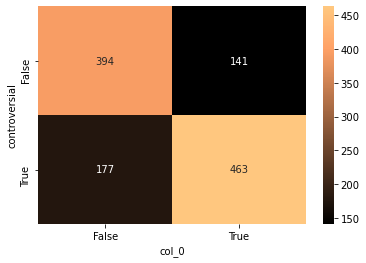

234.04698848724365 seconds


In [97]:
# Random forest CBOW

# params to compare
params = {
    'criterion': ['entropy','gini'],
}

# implement the clf
clf= ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1
)

score_optimization(clf=clf, params=params, features="BOW", i=5)


 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best params:  {'learning_rate': 0.7}

Cross-val scores(All Data):  [0.70808511 0.68313458 0.62776831 0.71124361 0.68994889]
Mean cv score:  0.6840361013447389

Train Accuracy Score:  0.8245315161839863

Test Acc Score:  0.6995744680851064

Adjusted Rand-Index: 0.158
Homogeneity score: 0.113
Silhouette score:  0.019
Normed mutual-info score: 0.116
              precision    recall  f1-score   support

       False       0.71      0.58      0.64       535
        True       0.69      0.80      0.74       640

    accuracy                           0.70      1175
   macro avg       0.70      0.69      0.69      1175
weighted avg       0.70      0.70      0.70      1175



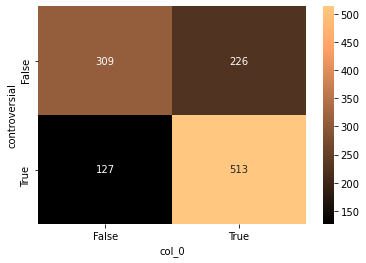

78.96189951896667 seconds


In [98]:
# gradient boosting CBOW
# params to compare
params = {
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

# implement the clf
clf= ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf, params=params, features='BOW', i=6)

In [99]:
performance.iloc[:7].sort_values('Mutual_Info', ascending=False)[['Algorithm', 'n_train', 'Features', 'Mutual_Info']]

,Algorithm,n_train,Features,Mutual_Info
5,RandomForestClassifier,NaN,BOW,0.157705
6,GradientBoostingClassifier,NaN,BOW,0.115732
4,LogisticRegression,NaN,BOW,0.104372
1,MeanShift,5871,BOW,0.0352752
0,KMeans,5871,BOW,0.00877557
3,SpectralClustering,5871,BOW,0.00675253
2,NaN,NaN,NaN,NaN


### TF-IDF

In [154]:

vectorizer = TfidfVectorizer(
    max_df=0.3,  # drop words that occur in more than 30% of docs
    min_df = 8,  # only use words appearing N times
    stop_words='english',
    lowercase=True,  # convert all to lower 
    use_idf=True,  # use inverse doc freq in weighting
    norm=u'l2',  # correction factor so longer paras and shorter paras are treated equally
    smooth_idf = True # adds 1 to all doc freqs, as if an extra doc that used each word once existed. Prevents divide by 0 errors.
)

# pass pandas series to our vectorizer model
counts_tfidf = vectorizer.fit_transform(bow_counts.title)

In [155]:
vectorizer.get_feature_names()[1000]

'raped'

In [156]:
vectorizer.idf_

array([4.78760144, 5.6348993 , 5.98907112, ..., 7.19304392, 7.37536548,
       7.19304392])

In [157]:
svd = TruncatedSVD(920)
svd.fit(counts_tfidf)
svd.explained_variance_ratio_.sum()

0.25318387976529083

In [158]:
svd.get_params()

{'algorithm': 'randomized',
 'n_components': 100,
 'n_iter': 5,
 'random_state': None,
 'tol': 0.0}

In [159]:
counts_tfidf_df = pd.DataFrame(counts_tfidf)
counts_tfidf_df.shape

(5871, 1)

In [160]:
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data.shape

(5871, 100)

In [161]:
lsa_data = pd.DataFrame(lsa_data)
lsa_data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.172289,0.196155,-0.046944,-0.230175,0.235570,0.246145,-0.083349,-0.043999,0.003901,0.105901,...,-0.040690,-0.104337,0.031475,0.042328,-0.076868,0.004281,0.053321,0.072474,0.028901,-0.046204
1,0.147027,-0.040537,0.033511,-0.027011,-0.044124,-0.056659,-0.115800,0.058801,0.371728,0.106888,...,0.029275,-0.023064,0.003042,-0.017877,0.015810,0.007570,0.019562,-0.093127,-0.013995,0.011336
2,0.062744,0.016801,0.019536,-0.092439,0.007974,-0.035260,0.055873,0.005059,0.037600,-0.095469,...,-0.217960,0.221089,-0.031970,-0.054439,0.098302,0.004708,0.001496,0.036388,0.050418,0.127122
3,0.172289,0.196155,-0.046944,-0.230175,0.235570,0.246145,-0.083349,-0.043999,0.003901,0.105901,...,-0.040690,-0.104337,0.031475,0.042328,-0.076868,0.004281,0.053321,0.072474,0.028901,-0.046204
4,0.147027,-0.040537,0.033511,-0.027011,-0.044124,-0.056659,-0.115800,0.058801,0.371728,0.106888,...,0.029275,-0.023064,0.003042,-0.017877,0.015810,0.007570,0.019562,-0.093127,-0.013995,0.011336


In [162]:
# clustering on LSA using the BOW content
# first establish X&Y

y = bow_counts['controversial']
X = lsa_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# X_train.to_csv('title_lsa_X_train.csv')
# X_test.to_csv('title_lsa_X_test.csv')
# y_train.to_csv('title_lsa_y_train.csv')
# y_test.to_csv('title_lsa_y_test.csv')

lsa_train = X_train
lsa_train['controversial'] = y_train
lsa_test = X_test
lsa_test ['controversial'] = y_test

# lsa_train.to_csv('title_lsa_train.csv')
# lsa_test.to_csv('title_lsa_test.csv')


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best params:  {'init': 'random', 'n_clusters': 25, 'n_init': 20, 'precompute_distances': True}
[17  6  4 ... 18 18  0]
Adjusted Rand-Index: 0.002
Homogeneity Score: 0.014
Silhouette Score: 0.089
Normalized Mutual-Info Score: 0.005


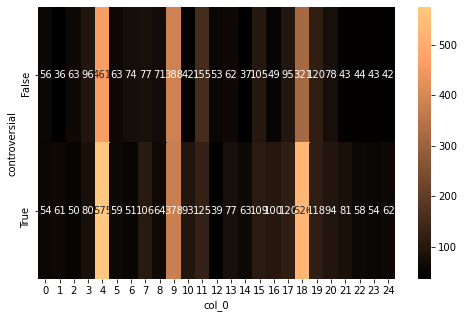

44.5451922416687  seconds.


In [163]:
# kmeans LSA
clust = KMeans()
params = {
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'precompute_distances': [True, False]
}
evaluate_clust(clust, params, features='LSA', i=7)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best params:  {'bandwidth': 0.5}
[ 486   29  145 ...  102 3442 3392]
Adjusted Rand-Index: 0.000
Homogeneity Score: 0.765
Silhouette Score: 0.329
Normalized Mutual-Info Score: 0.124


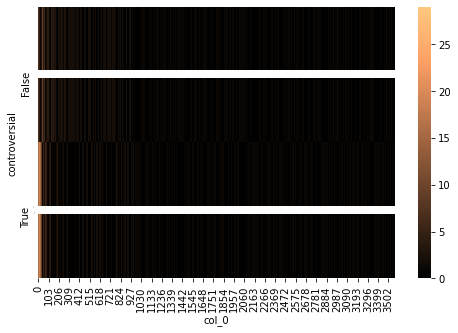

185.7201886177063  seconds.


In [164]:
# mean shift LSA
clust = MeanShift()

params ={
    'bandwidth':[0.5,0.7,0.9]
}

evaluate_clust(clust, params, features='LSA', i=8)

In [165]:
# affinity prop LSA

clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9],
    'max_iter': [200,500]
}
evaluate_clust(clust, params, features='LSA', i=9)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best params:  {'damping': 0.5, 'max_iter': 200}
[-1 -1 -1 ... -1 -1 -1]
Adjusted Rand-Index: 0.000
Homogeneity Score: 0.000


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
# spectral clustering LSA

clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='LSA'

i=10

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

In [111]:
performance.iloc[:11].sort_values(
    'Mutual_Info', ascending=False
)[['Algorithm', 'n_train', 'Features', 'Mutual_Info', 'Test_accuracy']]

,Algorithm,n_train,Features,Mutual_Info,Test_accuracy
5,RandomForestClassifier,NaN,BOW,0.157705,NaN
8,MeanShift,5871,LSA,0.150341,NaN
6,GradientBoostingClassifier,NaN,BOW,0.115732,NaN
4,LogisticRegression,NaN,BOW,0.104372,NaN
1,MeanShift,5871,BOW,0.0352752,NaN
7,KMeans,5871,LSA,0.00880451,NaN
0,KMeans,5871,BOW,0.00877557,NaN
3,SpectralClustering,5871,BOW,0.00675253,NaN
10,SpectralClustering,5871,LSA,0.00351432,NaN
2,NaN,NaN,NaN,NaN,NaN


In [ ]:
performance.iloc[:11].sort_values(
    'Mutual_Info', ascending=False
)[['Algorithm', 'n_train', 'Features', 'Mutual_Info', 'Test_accuracy']]


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best params:  {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Cross-val scores(All Data):  [0.70723404 0.66524702 0.60306644 0.68228279 0.66183986]
Mean cv score:  0.6639340316792925

Train Accuracy Score:  0.7700170357751278

Test Acc Score:  0.6757446808510639

Adjusted Rand-Index: 0.122
Homogeneity score: 0.086
Silhouette score:  0.002
Normed mutual-info score: 0.088
              precision    recall  f1-score   support

       False       0.68      0.56      0.61       535
        True       0.68      0.78      0.72       640

    accuracy                           0.68      1175
   macro avg       0.68      0.67      0.67      1175
weighted avg       0.68      0.68      0.67      1175



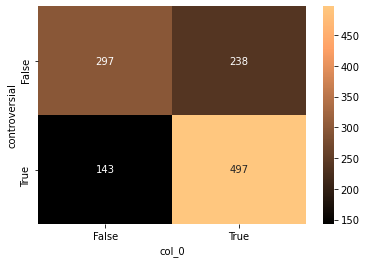

73.87904787063599 seconds


In [112]:
# classification on LSA (Bow Content)
# supervised

params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'C': [0.3, 0.5, 0.7, 1],
        'penalty':['l2']
    }, {
        'solver':['liblinear', 'saga'],
        'C': [0.3, 0.5, 0.7, 1],
        'penalty': ['l1','l2']
    }
]

clf = LogisticRegression(
    n_jobs=-1
)

score_optimization(clf=clf, params=params, features='LSA', i=11)


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best params:  {'criterion': 'gini'}

Cross-val scores(All Data):  [0.76851064 0.73764906 0.63202726 0.80664395 0.68228279]
Mean cv score:  0.7254227409474792

Train Accuracy Score:  0.998083475298126

Test Acc Score:  0.7251063829787234

Adjusted Rand-Index: 0.201
Homogeneity score: 0.150
Silhouette score:  0.002
Normed mutual-info score: 0.156
              precision    recall  f1-score   support

       False       0.77      0.57      0.65       535
        True       0.70      0.86      0.77       640

    accuracy                           0.73      1175
   macro avg       0.74      0.71      0.71      1175
weighted avg       0.73      0.73      0.72      1175



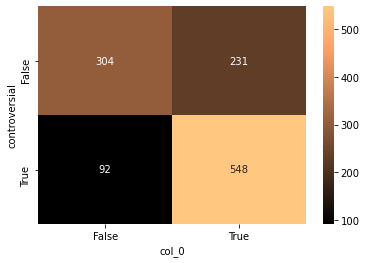

353.86747312545776 seconds


In [113]:
# random forest LSA on BOW data

params = {
    'criterion': ['entropy','gini']
}

# impl clf
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1
)

score_optimization(clf=clf, params=params, features='LSA', i=12)


 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best params:  {'learning_rate': 0.7}

Cross-val scores(All Data):  [0.69957447 0.72913118 0.61669506 0.80068143 0.66354344]
Mean cv score:  0.701925115082098

Train Accuracy Score:  0.9906303236797275

Test Acc Score:  0.6672340425531915

Adjusted Rand-Index: 0.111
Homogeneity score: 0.079
Silhouette score:  0.001
Normed mutual-info score: 0.079
              precision    recall  f1-score   support

       False       0.64      0.62      0.63       535
        True       0.69      0.71      0.70       640

    accuracy                           0.67      1175
   macro avg       0.66      0.66      0.66      1175
weighted avg       0.67      0.67      0.67      1175



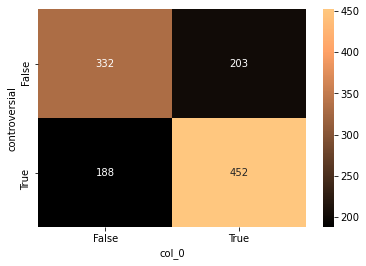

1879.259982585907 seconds


In [114]:
# gradient boosting 
params = {
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf, params, features='LSA', i=13)

In [115]:
performance.iloc[:14].sort_values('Mutual_Info', ascending=False)[['Algorithm','n_train', 'Features','Mutual_Info','Test_accuracy']].iloc[:9]

,Algorithm,n_train,Features,Mutual_Info,Test_accuracy
5,RandomForestClassifier,NaN,BOW,0.157705,NaN
12,RandomForestClassifier,NaN,LSA,0.155756,NaN
8,MeanShift,5871,LSA,0.150341,NaN
6,GradientBoostingClassifier,NaN,BOW,0.115732,NaN
4,LogisticRegression,NaN,BOW,0.104372,NaN
11,LogisticRegression,NaN,LSA,0.0875483,NaN
13,GradientBoostingClassifier,NaN,LSA,0.0792417,NaN
1,MeanShift,5871,BOW,0.0352752,NaN
7,KMeans,5871,LSA,0.00880451,NaN


### Topic modeling

### Attitude shift

Semi-believable hahahaha

Weight folks w/ karma. 

Comments 
Top-voted
Controversial
If extended to comments just scrape controversial comments. 
Sort by controversial. 

Keep randomizing agent string. 
Random amount of delay b/w each ping.
Don't overdo it.
Filter by tag. p tags. New doc then .text. 
Watch out for encoding. Maybe explicitly set to Unicode. Unicode dammit fn. 

First, check and see if topics connect.
To build a better model, reduce false positives. Have 2 classes. 

Quick mick story.
Martin. UK researcher. Social scientist psych and programmer. Compu social science. 
No papers published in the UK. b/c all work was funding by MoD. Classified. 
Check intuition. Learn how diff aspects of cog psych socialogy and ML intersect. 
Most important outcomes is: any language there's fundamental way to understand when most important thing in text convo will happen.
Can understand which part has got th emost important info. Without ML. 
3 marker words. 
So, well, but. Conversational markers, as they always precede what's the most important opinion afterwards. 
This info is from topic modeling. 
I have all this stuff, how do I know what's important?

Moreover? 

Test, train, validation.

Research staff member shared w/ private biz. KTP? Key technical partner?